## Interference-Aware Scheduling to Avoid SLO Violations

This notebook builds our SLO-Aware, Interference-Conscious scheduling pipeline.  
We will:

1. **Ingest** raw performance (wrk2) and hardware-counter (PCM) data.  
2. **Profile** each interference scenario by aggregating PCM metrics into summary features.  
3. **Join** these features with the observed P99-latencies to form our ML dataset.  
4. **Preprocess** the features (scaling, polynomial expansion) and construct a reusable pipeline.  
5. **Train & Evaluate** multiple regression models (linear+poly, Random Forest, kNN) using leave-one-out CV.  
6. **Select** the best model to compute our `RiskScore = predicted_P99 / SLO_threshold`, which will guide scheduling decisions.


In [22]:
import os
import pandas as pd
from pathlib import Path
import glob
import matplotlib.pyplot as plt
import numpy as np
import json
import base64
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor


### 1.1 Fetch Data

In [3]:
# Define the local path to store the CSV files from the LabPC
local_results_folder = Path("./HR_Data")

# Create the folder if it does not already exist
local_results_folder.mkdir(parents=True, exist_ok=True)

print(f"Local results folder set to: {local_results_folder.resolve()}")

# Check if the folder exists and delete all files inside it
if local_results_folder.exists():
    for file in local_results_folder.iterdir():
        if file.is_file():
            file.unlink()
    print("All files in the folder have been deleted.")



Local results folder set to: /home/george/Workshop/Interference/profiling/HR_Data
All files in the folder have been deleted.


In [4]:
# Replace 'george@147.102.13.77' and the remote path with your actual credentials and remote paths
remote_path = "george@147.102.13.77:/home/george/Workspace/HR_Metrics_V01/*"

# Use shell command to securely copy all CSV files from remote
!scp {remote_path} {str(local_results_folder)}/ 

# enter passphrase for the remote server


pcm_core_metrics_TC-VM-01_baseline.csv        100% 7759     1.8MB/s   00:00    
pcm_core_metrics_TC-VM-01_cpu100.csv          100% 7103     1.4MB/s   00:00    
pcm_core_metrics_TC-VM-01_cpu12.5.csv         100% 6993     1.3MB/s   00:00    
pcm_core_metrics_TC-VM-01_cpu25.csv           100% 7077     1.3MB/s   00:00    
pcm_core_metrics_TC-VM-01_cpu50.csv           100% 6986     1.0MB/s   00:00    
pcm_core_metrics_TC-VM-01_l3_1.csv            100% 6973     1.6MB/s   00:00    
pcm_core_metrics_TC-VM-01_l3_2.csv            100% 7732     1.7MB/s   00:00    
pcm_core_metrics_TC-VM-01_l3_4.csv            100% 6998     1.4MB/s   00:00    
pcm_core_metrics_TC-VM-01_membw_1.csv         100% 7759     1.4MB/s   00:00    
pcm_core_metrics_TC-VM-01_membw_2.csv         100% 6973     1.6MB/s   00:00    
pcm_core_metrics_TC-VM-01_membw_4.csv         100% 6973     1.3MB/s   00:00    
pcm_core_metrics_TC-VM-01_membw_8.csv         100% 7024   924.1KB/s   00:00    
pcm_system_metrics_TC-VM-01_baseline.csv

In [5]:
# List all CSV files in the local_results_folder
csv_files = list(local_results_folder.glob("*.csv"))

if not csv_files:
    print("No CSV files found in the directory. Check SCP or paths.")
else:
    for f in csv_files:
        # Number of rows and columns in the CSV file
        num_rows = sum(1 for _ in open(f))
        num_cols = len(pd.read_csv(f, nrows=0).columns)
        print(f"File: {f.name}, Rows: {num_rows}, Columns: {num_cols}")


File: pcm_system_metrics_TC-VM-01_l3_1.csv, Rows: 14, Columns: 14
File: pcm_system_metrics_TC-VM-01_membw_8.csv, Rows: 14, Columns: 14
File: pcm_system_metrics_TC-VM-01_l3_4.csv, Rows: 14, Columns: 14
File: pcm_system_metrics_TC-VM-01_cpu12.5.csv, Rows: 14, Columns: 14
File: perf_metrics_TC-VM-01_membw_8.csv, Rows: 14, Columns: 19
File: pcm_core_metrics_TC-VM-01_cpu50.csv, Rows: 14, Columns: 72
File: pcm_core_metrics_TC-VM-01_l3_1.csv, Rows: 14, Columns: 72
File: perf_metrics_TC-VM-01_l3_2.csv, Rows: 14, Columns: 19
File: pcm_system_metrics_TC-VM-01_membw_2.csv, Rows: 12, Columns: 14
File: perf_metrics_TC-VM-01_cpu50.csv, Rows: 14, Columns: 19
File: pcm_core_metrics_TC-VM-01_cpu25.csv, Rows: 14, Columns: 72
File: pcm_core_metrics_TC-VM-01_cpu100.csv, Rows: 14, Columns: 72
File: pcm_core_metrics_TC-VM-01_membw_4.csv, Rows: 14, Columns: 72
File: perf_metrics_TC-VM-01_l3_1.csv, Rows: 14, Columns: 19
File: workload_metrics.csv, Rows: 13, Columns: 10
File: perf_metrics_TC-VM-01_membw_2.csv,

### 1.2 View Data

In [6]:
file_patterns = {
    "perf": "*perf*.csv",
    "pcm_system": "*pcm_system*.csv",
    "pcm_cores": "*pcm_core*.csv",
    #"container_detail": "*container_metrics_detail*.csv",
    #"container_agg": "*container_metrics_agg*.csv",
    "workload": "*workload*.csv",
}

In [1]:
interference_snenarios = ["baseline", "cpu_1_pod", "cpu_2_pod", "cpu_4_pod", "cpu_8_pod", "l3_1_pod", "l3_2_pod", "l3_4_pod", "membw_1_pod", "membw_2_pod", "membw_4_pod", "membw_8_pod"]

#### Example of each data file

In [8]:
# Loop through each category and find the first matching CSV file.
for category, pattern in file_patterns.items():
    # Construct the search pattern
    search_pattern = os.path.join(local_results_folder, pattern)
    matching_files = glob.glob(search_pattern)
    
    # Check if there is at least one matching file
    if matching_files:
        # Select the first matching file
        selected_file = matching_files[0]
        
        # Read the CSV into a DataFrame
        df = pd.read_csv(selected_file)
        
        # Optionally, re-save the file with comma as separator and without the index.
        # If you prefer to keep the original file intact, you can comment out the next line.
        df.to_csv(selected_file, sep=",", index=False)
        
        print(f"=== Category: {category} - File: {os.path.basename(selected_file)} ===")
        display(df.head(5))  # Use display() if you're in a Jupyter Notebook, otherwise use print(df.head(5))
        print("\n")
    else:
        print(f"No file found for the category: {category}\n")

=== Category: perf - File: perf_metrics_TC-VM-01_membw_8.csv ===


,time,task-clock,branches,branch-instructions,branch-misses,stalled-cycles-frontend,stalled-cycles-backend,bus-cycles,cache-references,cache-misses,LLC-loads,LLC-load-misses,LLC-stores,LLC-store-misses,cycle_activity.stalls_l3_miss,mem-loads,mem-stores,dtlb_load_misses.stlb_hit,page-faults
0,5.004827,NaN,7997599899,8012171785,75858639,NaN,NaN,1419438597,986639219,490575701,73158790,31248806,283401531,270786738,33827208781,0,7286327051,152387196,50301
1,10.010874,NaN,8013597833,8058062858,82321498,NaN,NaN,1503041542,1011164355,480092369,81070114,35827250,303413304,289921505,41142842094,0,7256070254,169313824,7957
2,15.016913,NaN,8289638513,8317646548,87166831,NaN,NaN,1502023229,1048407736,480489033,87258464,35290227,306903739,289366787,40497208692,0,7446739153,180050731,4248
3,20.022846,NaN,8389634250,8410018707,87657581,NaN,NaN,1502491402,1021743139,481230917,84616984,35852615,306008916,289526691,40222555268,0,7439010932,178003330,6462
4,25.028837,NaN,8079704642,8112740825,81942239,NaN,NaN,1503845520,1022762572,479903822,81081347,35209810,301435457,286135477,41365981797,0,7317789693,167050204,4892




=== Category: pcm_system - File: pcm_system_metrics_TC-VM-01_l3_1.csv ===


,System - Date,System - Time,System - IPC,System - L3MISS,System - L2MISS,System - READ,System - WRITE,System - PhysIPC,System - PhysIPC%,System Core C-States - C0res%,System Core C-States - C1res%,System Core C-States - C6res%,System Pack C-States - C0res%,System Pack C-States - C6res%
0,2025-04-29,18:06:43.203,0.63,2.68,6.47,31.81,19.81,1.27,25.33,4.97,90.29,0.0,100.0,0.0
1,2025-04-29,18:06:48.203,0.51,3.27,7.90,38.82,23.73,1.03,20.54,5.96,94.04,0.0,100.0,0.0
2,2025-04-29,18:06:53.204,0.50,3.20,8.03,38.67,23.50,1.00,20.09,5.93,94.07,0.0,100.0,0.0
3,2025-04-29,18:06:58.204,0.50,3.30,7.91,38.86,23.64,1.00,20.09,5.98,94.02,0.0,100.0,0.0
4,2025-04-29,18:07:03.203,0.52,3.33,7.84,38.77,24.07,1.03,20.61,5.95,94.05,0.0,100.0,0.0




=== Category: pcm_cores - File: pcm_core_metrics_TC-VM-01_cpu50.csv ===


,System - Date,System - Time,System Core C-States - C0res%,System Core C-States - C1res%,System Core C-States - C6res%,SKT0 Core C-State - C0res%,SKT0 Core C-State - C1res%,SKT0 Core C-State - C6res%,Core0 (Socket 0) - IPC,Core0 (Socket 0) - L3MISS,...,Core6 (Socket 0) - PhysIPC,Core6 (Socket 0) - PhysIPC%,Core7 (Socket 0) - IPC,Core7 (Socket 0) - L3MISS,Core7 (Socket 0) - L2MISS,Core7 (Socket 0) - C0res%,Core7 (Socket 0) - C1res%,Core7 (Socket 0) - C6res%,Core7 (Socket 0) - PhysIPC,Core7 (Socket 0) - PhysIPC%
0,2025-04-29,17:45:10.927,6.87,91.91,0.0,6.87,91.91,0.0,1.01,0.23,...,2.00,39.92,1.05,0.20,0.76,5.54,93.83,0.0,2.09,41.82
1,2025-04-29,17:45:15.927,7.66,92.34,0.0,7.66,92.34,0.0,1.01,0.23,...,1.94,38.88,1.00,0.27,1.00,6.11,93.89,0.0,2.00,39.96
2,2025-04-29,17:45:20.927,7.65,92.35,0.0,7.65,92.35,0.0,1.01,0.23,...,2.12,42.32,0.94,0.33,1.35,6.19,93.81,0.0,1.87,37.50
3,2025-04-29,17:45:25.927,7.64,92.36,0.0,7.64,92.36,0.0,1.01,0.25,...,1.81,36.22,1.04,0.22,0.82,6.12,93.88,0.0,2.07,41.40
4,2025-04-29,17:45:30.927,7.65,92.35,0.0,7.65,92.35,0.0,1.02,0.25,...,2.13,42.63,0.92,0.35,1.29,6.18,93.82,0.0,1.84,36.80




=== Category: workload - File: workload_metrics.csv ===


,TestCaseID,Interference,Date,Throughput,Avg_Latency,P50_Latency,P75_Latency,P90_Latency,P99_Latency,Max_Latency
0,TC-VM-01,baseline,2025-04-29,989.65,4850.0,3650.0,6120.0,9430.0,19200.0,72450.0
1,TC-VM-01,cpu12.5,2025-04-29,995.24,7360.0,5510.0,9610.0,15190.0,28740.0,85180.0
2,TC-VM-01,cpu25,2025-04-29,995.16,12960.0,9250.0,17690.0,28210.0,51260.0,125950.0
3,TC-VM-01,cpu50,2025-04-29,985.14,466440.0,328190.0,633850.0,1050000.0,2080000.0,4530000.0
4,TC-VM-01,cpu100,2025-04-29,685.76,10670000.0,10530000.0,14530000.0,17380000.0,21170000.0,24230000.0


#### Columns in each data file

In [9]:
# Show the list of columns for each category
for category, pattern in file_patterns.items():
    # Construct the search pattern
    search_pattern = os.path.join(local_results_folder, pattern)
    matching_files = glob.glob(search_pattern)
    
    # Check if there is at least one matching file
    if matching_files:
        # Select the first matching file
        selected_file = matching_files[0]
        
        # Read the CSV into a DataFrame
        df = pd.read_csv(selected_file)
        
        print(f"=== Category: {category} - File: {os.path.basename(selected_file)} ===")
        print(df.columns.tolist())
        print("\n")
    else:
        print(f"No file found for the category: {category}\n")

=== Category: perf - File: perf_metrics_TC-VM-01_membw_8.csv ===
['time', 'task-clock', 'branches', 'branch-instructions', 'branch-misses', 'stalled-cycles-frontend', 'stalled-cycles-backend', 'bus-cycles', 'cache-references', 'cache-misses', 'LLC-loads', 'LLC-load-misses', 'LLC-stores', 'LLC-store-misses', 'cycle_activity.stalls_l3_miss', 'mem-loads', 'mem-stores', 'dtlb_load_misses.stlb_hit', 'page-faults']


=== Category: pcm_system - File: pcm_system_metrics_TC-VM-01_l3_1.csv ===
['System - Date', 'System - Time', 'System - IPC', 'System - L3MISS', 'System - L2MISS', 'System - READ', 'System - WRITE', 'System - PhysIPC', 'System - PhysIPC%', 'System Core C-States - C0res%', 'System Core C-States - C1res%', 'System Core C-States - C6res%', 'System Pack C-States - C0res%', 'System Pack C-States - C6res%']


=== Category: pcm_cores - File: pcm_core_metrics_TC-VM-01_cpu50.csv ===
['System - Date', 'System - Time', 'System Core C-States - C0res%', 'System Core C-States - C1res%', 'Syste

### 1.3 Load Data into Dataframes

In [7]:
Data_Dir_HR = 'HR_Data'
traffic = 'TC-VM-01'
Perfomance_File_HR = os.path.join(Data_Dir_HR, 'workload_metrics.csv')


if os.path.exists(Perfomance_File_HR):
    df_perf = pd.read_csv(Perfomance_File_HR)
    print("Loaded performance metrics:")
    display(df_perf.head())
else:
    print(f"Performance file not found at {Perfomance_File_HR}. Please verify path.")
    df_perf = pd.DataFrame()



Loaded performance metrics:


,TestCaseID,Interference,Date,Throughput,Avg_Latency,P50_Latency,P75_Latency,P90_Latency,P99_Latency,Max_Latency
0,TC-VM-01,baseline,2025-04-29,989.65,4850.0,3650.0,6120.0,9430.0,19200.0,72450.0
1,TC-VM-01,cpu12.5,2025-04-29,995.24,7360.0,5510.0,9610.0,15190.0,28740.0,85180.0
2,TC-VM-01,cpu25,2025-04-29,995.16,12960.0,9250.0,17690.0,28210.0,51260.0,125950.0
3,TC-VM-01,cpu50,2025-04-29,985.14,466440.0,328190.0,633850.0,1050000.0,2080000.0,4530000.0
4,TC-VM-01,cpu100,2025-04-29,685.76,10670000.0,10530000.0,14530000.0,17380000.0,21170000.0,24230000.0


In [ ]:
## For PCM Files

# Helper to clean column names
def clean_col(col):
    col = col.replace('System - ', '')
    col = col.replace('System Core C-States - ', 'core_c_')
    col = col.replace('System Pack C-States - ', 'pack_c_')
    col = col.replace(' ', '_').replace('-', '').lower()
    return col

## 2. Perfomance

1) Normalized Throughput Performance (NTP)

   Definition:
     NTP = Measured_Throughput / Baseline_Throughput

   Parameters:
   - Measured_Throughput: The throughput of the workload under interference (e.g., "Throughput" field in the CSV for a given scenario).
   - Baseline_Throughput: The throughput of the workload under the baseline (no interference). Typically, this is the “Throughput” value from a row where "Interference" = "baseline".

   Interpretation:
   - NTP > 1  => Application throughput exceeded the baseline
   - NTP < 1  => Application throughput degraded relative to baseline
   - NTP = 1  => No observed change vs. baseline


2) Normalized Latency Performance (NLP)

   Definition:
     NLP = Measured_Latency / Baseline_Latency

   Parameters:
   - Measured_Latency: A latency statistic (e.g., "Avg_Latency", "P90_Latency", "P99_Latency") for the scenario under interference.
   - Baseline_Latency: The corresponding latency statistic from the baseline scenario (where "Interference" = "baseline").

   Interpretation:
   - NLP > 1  => Latency is higher (worse) than baseline
   - NLP < 1  => Latency is lower (better) than baseline
   - NLP = 1  => No change in latency vs. baseline

   Note:
   You may apply NLP to any latency metric: P50, P75, P90, P99, etc. Choose whichever best suits your SLA or QoS focus.


3) QoS Degradation

   Definition (as a % increase in latency):
     QoS Degradation(%) = ((Measured_Latency - Baseline_Latency) / Baseline_Latency) * 100

   Parameters:
   - Measured_Latency: The same “Avg_Latency” or tail latency (e.g., "P99_Latency") under interference.
   - Baseline_Latency: The same latency value in the baseline scenario.

   Interpretation:
   - A positive value indicates how many percentage points slower the application is compared to the baseline.
   - Example: If baseline latency is 100 ms, and measured latency is 150 ms, QoS Degradation = ((150 - 100) / 100) * 100 = 50%


4) SLA Violations

   Definition:
     SLA Violations measure how often a latency threshold (e.g., “P99_Latency < 200 ms”) is exceeded.

   Common Calculation Approach:
     - Choose a latency statistic relevant to your SLA (e.g., P90, P99, or Max_Latency).
     - Define an SLA threshold T (e.g., 200 ms for P99 latency).
     - Count how many runs (or samples) exceed that threshold.
       SLA_Violation_Rate = (Number_of_Samples_Exceeding_T / Total_Samples) * 100

   Parameters:
   - P99_Latency (or whichever percentile you track) from the CSV for each interference scenario.
   - A chosen threshold T that represents your SLA limit.

   Note:
   If you are measuring SLA on a per-request basis rather than per-scenario, you would track the percentage of requests whose latency exceeded T. For scenario-level data, you can say a “violation” occurs if P99_Latency > T in that test case.

-----
Summary of Usage:

- “Baseline_*” values are typically taken from rows where `Interference = "baseline"`.
- For each test case under interference (e.g., `cpu100`, `membw100`, etc.), compute:
  1. Normalized Throughput = Throughput / Baseline_Throughput
  2. Normalized Latency   = (e.g.) P99_Latency / Baseline_P99_Latency
  3. QoS Degradation(%)   = ((P99_Latency - Baseline_P99_Latency) / Baseline_P99_Latency) * 100
  4. SLA Violation Rate   = Percentage of test cases (or requests) exceeding a given SLA threshold T


### 2.1 Impact on Performance

In [13]:
import pandas as pd

# 1) Load the one‐row‐per‐scenario workload metrics
wl = pd.read_csv("HR_Data/workload_metrics.csv")

# 2) Define the exact labels present in wl for each category
cpu_labels   = ["baseline", "cpu12.5", "cpu25",   "cpu50",   "cpu100"]
l3_labels    = ["baseline", "l3_1",    "l3_2",    "l3_4"]
membw_labels = ["baseline", "membw_1", "membw_2", "membw_4", "membw_8"]

# 3) Subset into three DataFrames
cpu_df   = wl[wl["Interference"].isin(cpu_labels)].copy()
l3_df    = wl[wl["Interference"].isin(l3_labels)].copy()
membw_df = wl[wl["Interference"].isin(membw_labels)].copy()

# 4) Compute a unified pod_count column:
#    - baseline → 0
#    - cpuXX → XX/12.5  (because 12.5% CPU = 1 pod, 25% = 2 pods, etc.)
#    - l3_N    → N pods
#    - membw_N → N pods
def pod_count(interf):
    if interf == "baseline":
        return 0
    if interf.startswith("cpu"):
        pct = float(interf.replace("cpu",""))
        return int(pct / 12.5)
    if interf.startswith("l3_"):
        return int(interf.split("_")[1])
    if interf.startswith("membw_"):
        return int(interf.split("_")[1])
    return None

for df in (cpu_df, l3_df, membw_df):
    df["pod_count"] = df["Interference"].apply(pod_count)

# 5) Inspect the resulting DataFrames
print("=== CPU DataFrame ===")
print(cpu_df.to_string(index=False), "\n")

print("=== L3 DataFrame ===")
print(l3_df.to_string(index=False), "\n")

print("=== MemBW DataFrame ===")
print(membw_df.to_string(index=False), "\n")


=== CPU DataFrame ===
TestCaseID Interference       Date  Throughput  Avg_Latency  P50_Latency  P75_Latency  P90_Latency  P99_Latency  Max_Latency  pod_count
  TC-VM-01     baseline 2025-04-29      989.65       4850.0       3650.0       6120.0       9430.0      19200.0      72450.0          0
  TC-VM-01      cpu12.5 2025-04-29      995.24       7360.0       5510.0       9610.0      15190.0      28740.0      85180.0          1
  TC-VM-01        cpu25 2025-04-29      995.16      12960.0       9250.0      17690.0      28210.0      51260.0     125950.0          2
  TC-VM-01        cpu50 2025-04-29      985.14     466440.0     328190.0     633850.0    1050000.0    2080000.0    4530000.0          4
  TC-VM-01       cpu100 2025-04-29      685.76   10670000.0   10530000.0   14530000.0   17380000.0   21170000.0   24230000.0          8 

=== L3 DataFrame ===
TestCaseID Interference       Date  Throughput  Avg_Latency  P50_Latency  P75_Latency  P90_Latency  P99_Latency  Max_Latency  pod_count
  T

### 2.2 Normalized Perfomance (P99_Latency)

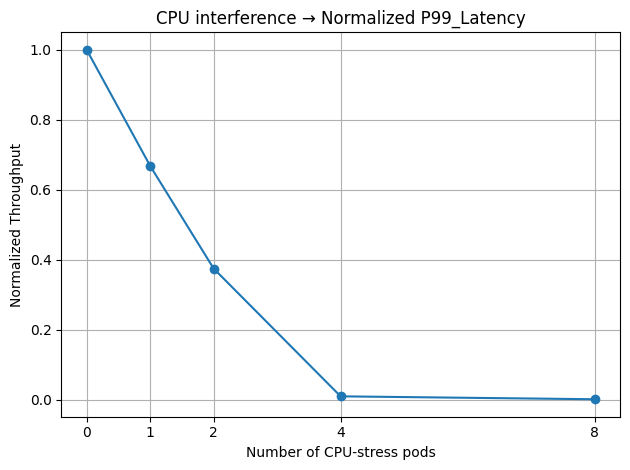

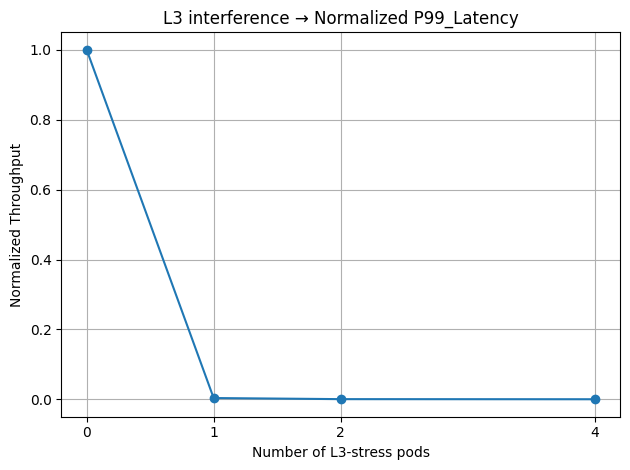

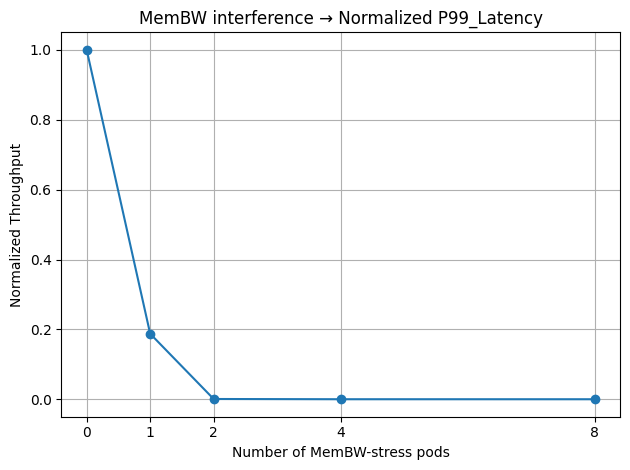

,TestCaseID,Interference,Date,Throughput,Avg_Latency,P50_Latency,P75_Latency,P90_Latency,P99_Latency,Max_Latency,pod_count,norm_tp
0,TC-VM-01,baseline,2025-04-29,989.65,4850.0,3650.0,6120.0,9430.0,19200.0,72450.0,0,1.000000
1,TC-VM-01,cpu12.5,2025-04-29,995.24,7360.0,5510.0,9610.0,15190.0,28740.0,85180.0,1,0.668058
2,TC-VM-01,cpu25,2025-04-29,995.16,12960.0,9250.0,17690.0,28210.0,51260.0,125950.0,2,0.374561
3,TC-VM-01,cpu50,2025-04-29,985.14,466440.0,328190.0,633850.0,1050000.0,2080000.0,4530000.0,4,0.009231
4,TC-VM-01,cpu100,2025-04-29,685.76,10670000.0,10530000.0,14530000.0,17380000.0,21170000.0,24230000.0,8,0.000907


,TestCaseID,Interference,Date,Throughput,Avg_Latency,P50_Latency,P75_Latency,P90_Latency,P99_Latency,Max_Latency,pod_count,norm_tp
0,TC-VM-01,baseline,2025-04-29,989.65,4850.0,3650.0,6120.0,9430.0,19200.0,72450.0,0,1.000000
5,TC-VM-01,l3_1,2025-04-29,968.02,1340000.0,989700.0,1940000.0,3070000.0,4970000.0,7620000.0,1,0.003863
6,TC-VM-01,l3_2,2025-04-29,596.68,13570000.0,13160000.0,18600000.0,22090000.0,26480000.0,28880000.0,2,0.000725
7,TC-VM-01,l3_4,2025-04-29,186.05,28820000.0,28820000.0,40470000.0,44790000.0,48560000.0,NaN,4,0.000395


,TestCaseID,Interference,Date,Throughput,Avg_Latency,P50_Latency,P75_Latency,P90_Latency,P99_Latency,Max_Latency,pod_count,norm_tp
0,TC-VM-01,baseline,2025-04-29,989.65,4850.0,3650.0,6120.0,9430.0,19200.0,72450.0,0,1.000000
8,TC-VM-01,membw_1,2025-04-29,994.70,24720.0,18300.0,32610.0,51010.0,102210.0,288000.0,1,0.187849
9,TC-VM-01,membw_2,2025-04-29,771.89,8070000.0,7860000.0,10930000.0,13480000.0,16970000.0,19270000.0,2,0.001131
10,TC-VM-01,membw_4,2025-04-29,300.64,24200000.0,23990000.0,33010000.0,38470000.0,42470000.0,46100000.0,4,0.000452
11,TC-VM-01,membw_8,2025-04-29,207.47,27450000.0,27820000.0,37030000.0,43380000.0,47840000.0,50070000.0,8,0.000401


In [14]:
import matplotlib.pyplot as plt

# 1) Compute baseline throughput per TestCaseID
baseline_tp = wl[wl["Interference"] == "baseline"] .set_index("TestCaseID")["P99_Latency"]

# 2) Add normalized-throughput column to each df
for df in (cpu_df, l3_df, membw_df): 
    df["norm_tp"] = 1/(df["P99_Latency"] / df["TestCaseID"].map(baseline_tp))

# 3) Plot for each category
for df, label in [
    (cpu_df,   "CPU"),
    (l3_df,    "L3"),
    (membw_df, "MemBW")
]:
    sub = df.sort_values("pod_count")
    plt.figure()
    plt.plot(sub["pod_count"], sub["norm_tp"], marker="o", linestyle="-")
    plt.title(f"{label} interference → Normalized P99_Latency")
    plt.xlabel(f"Number of {label}-stress pods")
    plt.ylabel("Normalized Throughput")
    plt.xticks(sub["pod_count"].unique())
    plt.grid(True)
    plt.tight_layout()
    plt.show()

display(cpu_df.head(5))
display(l3_df.head(5))
display(membw_df.head(5))


### 2.3 QoS Degradation

### 2.4 SLA Violation

##  3 Profiling

### 3.1. Application Profiling (Feature Extraction)

**Objective:** For each interference scenario, aggregate high-resolution PCM counters into a fixed set of summary features.  
- Compute the **mean** and **95th percentile** for each numeric counter (IPC, cache misses, memory bandwidth, C-state residencies, etc.).  
- Label each feature vector with its `Interference` scenario name so we can join later.


In [11]:
def extract_pcm_features(data_dir):
    pcm_pattern = os.path.join(data_dir, f'pcm_system_metrics_{traffic}_*.csv')
    pcm_files = glob.glob(pcm_pattern)
    if pcm_files:
        feature_list = []
        for filepath in pcm_files:
            fname = os.path.basename(filepath)
            interference = fname.replace(f'pcm_system_metrics_{traffic}_', '').replace('.csv', '')
            
            df_pcm = pd.read_csv(filepath)
            numeric_cols = df_pcm.select_dtypes(include=[np.number]).columns

            # Drop columns that are not needed: System Pack C-States, System - PhysIPC, System - PhysIPC%
            numeric_cols = [col for col in numeric_cols if "System Pack C-States" not in col and "System - PhysIPC" not in col and "System - PhysIPC%" not in col]

            # Aggregate: mean & 95th percentile
            feat_mean = df_pcm[numeric_cols].mean().rename(
                index={col: 'mean_' + clean_col(col) for col in numeric_cols}
            )
            feat_p95 = df_pcm[numeric_cols].quantile(0.95).rename(
                index={col: 'p95_' + clean_col(col) for col in numeric_cols}
            )
            
            # Build feature vector
            features = pd.concat([feat_mean, feat_p95]).to_frame().T
            features['Interference'] = interference
            feature_list.append(features)
        
        df_features = pd.concat(feature_list, ignore_index=True)
        print(df_features.shape)
        print("Extracted feature summaries:")
        display(df_features)
    else:
        print(f"⚠️ No PCM files found with pattern: {pcm_pattern}")
        df_features = pd.DataFrame()

    # Show columns
    print("Columns in df_features:")
    print(df_features.columns.tolist())
    return df_features

In [12]:
df_features_HR = extract_pcm_features(Data_Dir_HR)

(12, 17)
Extracted feature summaries:


,mean_ipc,mean_l3miss,mean_l2miss,mean_read,mean_write,mean_core_c_c0res%,mean_core_c_c1res%,mean_core_c_c6res%,p95_ipc,p95_l3miss,p95_l2miss,p95_read,p95_write,p95_core_c_c0res%,p95_core_c_c1res%,p95_core_c_c6res%,Interference
0,0.563077,3.065385,7.523077,36.531538,22.444615,5.660000,93.080769,0.0,0.838,3.346,8.042,38.864,23.926,5.988,94.064,0.0,l3_1
1,0.403846,2.436154,5.569231,46.056923,19.949231,9.075385,90.924615,0.0,0.422,2.564,6.050,46.262,20.432,9.124,91.080,0.0,membw_8
2,0.196923,1.956923,4.430769,33.036154,25.839231,11.219231,88.780769,0.0,0.248,2.292,5.438,33.618,26.658,11.294,89.022,0.0,l3_4
3,0.782308,4.233846,18.666923,26.198462,4.885385,8.035385,90.130769,0.0,0.868,4.726,20.626,28.512,5.344,8.742,91.568,0.0,cpu12.5
4,0.532727,2.380909,6.992727,47.489091,18.850000,5.949091,93.803636,0.0,0.555,2.445,7.225,48.080,19.565,6.055,94.005,0.0,membw_2
5,0.688000,2.500667,9.185333,45.339333,16.109333,4.986000,92.150667,0.0,1.110,2.859,10.490,47.144,17.090,5.559,94.512,0.0,membw_1
6,1.060000,5.318462,21.188462,12.633846,3.451538,20.768462,79.164615,0.0,1.080,5.654,22.654,13.098,3.524,20.954,79.382,0.0,cpu100
7,0.664667,2.422667,10.906000,26.469333,4.767333,3.942000,92.227333,0.0,0.728,2.982,13.026,31.395,5.996,4.730,95.630,0.0,baseline
8,1.014615,2.463077,9.247692,16.290769,4.386923,7.380000,92.074615,0.0,1.086,2.758,10.340,17.692,4.780,7.680,92.354,0.0,cpu50
9,0.334000,1.878000,5.114667,36.386667,24.922667,5.914667,93.938667,0.0,0.374,1.972,5.300,36.771,26.164,6.080,94.091,0.0,l3_2


Columns in df_features:
['mean_ipc', 'mean_l3miss', 'mean_l2miss', 'mean_read', 'mean_write', 'mean_core_c_c0res%', 'mean_core_c_c1res%', 'mean_core_c_c6res%', 'p95_ipc', 'p95_l3miss', 'p95_l2miss', 'p95_read', 'p95_write', 'p95_core_c_c0res%', 'p95_core_c_c1res%', 'p95_core_c_c6res%', 'Interference']


95th Percentile on PCM Counters:

When summarizing high-resolution counter streams into fixed features, the **mean** captures average behavior but can miss intermittent yet impactful bursts. Computing the **95th percentile** for each metric (e.g., IPC, cache misses, memory bandwidth) lets us quantify those sustained high-interference windows without over-reacting to single outliers.  
- **Captures “Spikiness”**: If a resource experiences occasional but prolonged contention, the 95th percentile rises, signaling potential tail-latency issues.  
- **Predicts Tail Latency**: Rare but sustained high counter values often drive P99 latency spikes. Including a high-percentile feature gives our model the ability to link resource “bursts” to service-level objective (SLO) violations.  
- **Robustness**: Unlike the maximum, the 95th percentile is less sensitive to one-off anomalies, yet still focuses on the worst 5% of the sampling windows—precisely the behavior most correlated with tail performance degradation.


### 3.2. Label Joining

**Objective:** Combine the profiled features (`df_features`) with the P99-latencies in `df_perf` to produce our ML-ready dataset (`df_ml`).  
- Each row in `df_ml` now represents one complete experiment: its hardware signature and the matching observed tail latency.


In [15]:
if not df_perf.empty and not df_features_HR.empty:
    df_ml = df_features_HR.merge(df_perf, on='Interference', how='inner')
    print("Combined ML-ready dataset:")
    display(df_ml.head())
else:
    df_ml = pd.DataFrame()
    print("⚠️ Cannot create ML dataset: missing performance or feature data.")

# Show columns of the final dataset
print("Final dataset columns:")
print(df_ml.columns.tolist())

Combined ML-ready dataset:


,mean_ipc,mean_l3miss,mean_l2miss,mean_read,mean_write,mean_core_c_c0res%,mean_core_c_c1res%,mean_core_c_c6res%,p95_ipc,p95_l3miss,...,Interference,TestCaseID,Date,Throughput,Avg_Latency,P50_Latency,P75_Latency,P90_Latency,P99_Latency,Max_Latency
0,0.563077,3.065385,7.523077,36.531538,22.444615,5.660000,93.080769,0.0,0.838,3.346,...,l3_1,TC-VM-01,2025-04-29,968.02,1340000.0,989700.0,1940000.0,3070000.0,4970000.0,7620000.0
1,0.403846,2.436154,5.569231,46.056923,19.949231,9.075385,90.924615,0.0,0.422,2.564,...,membw_8,TC-VM-01,2025-04-29,207.47,27450000.0,27820000.0,37030000.0,43380000.0,47840000.0,50070000.0
2,0.196923,1.956923,4.430769,33.036154,25.839231,11.219231,88.780769,0.0,0.248,2.292,...,l3_4,TC-VM-01,2025-04-29,186.05,28820000.0,28820000.0,40470000.0,44790000.0,48560000.0,NaN
3,0.782308,4.233846,18.666923,26.198462,4.885385,8.035385,90.130769,0.0,0.868,4.726,...,cpu12.5,TC-VM-01,2025-04-29,995.24,7360.0,5510.0,9610.0,15190.0,28740.0,85180.0
4,0.532727,2.380909,6.992727,47.489091,18.850000,5.949091,93.803636,0.0,0.555,2.445,...,membw_2,TC-VM-01,2025-04-29,771.89,8070000.0,7860000.0,10930000.0,13480000.0,16970000.0,19270000.0


Final dataset columns:
['mean_ipc', 'mean_l3miss', 'mean_l2miss', 'mean_read', 'mean_write', 'mean_core_c_c0res%', 'mean_core_c_c1res%', 'mean_core_c_c6res%', 'p95_ipc', 'p95_l3miss', 'p95_l2miss', 'p95_read', 'p95_write', 'p95_core_c_c0res%', 'p95_core_c_c1res%', 'p95_core_c_c6res%', 'Interference', 'TestCaseID', 'Date', 'Throughput', 'Avg_Latency', 'P50_Latency', 'P75_Latency', 'P90_Latency', 'P99_Latency', 'Max_Latency']


### 3.3. Preprocessing & Pipeline Construction

**Objective:** Build a scikit-learn `Pipeline` to transform raw features into model-ready inputs.  
- **StandardScaler** normalizes each feature to zero mean and unit variance.  
- **PolynomialFeatures(degree=2)** adds all pairwise interaction and squared terms to capture non-linear effects.  
- Wrapping these in a `Pipeline` ensures consistent transforms during training and inference.


In [18]:
# 1. Identify feature columns (mean_ and p95_ prefixes) and target
feature_cols = [col for col in df_ml.columns if col.startswith('mean_') or col.startswith('p95_')]
X = df_ml[feature_cols]
y = df_ml['P99_Latency']

# 2. Build the preprocessing pipeline
preprocessor = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

# 3. Fit and transform the features
X_preprocessed = preprocessor.fit_transform(X)

# Display shapes for verification
print(f"Original feature matrix shape: {X.shape}")
print(f"Preprocessed feature matrix shape: {X_preprocessed.shape}")

Original feature matrix shape: (12, 16)
Preprocessed feature matrix shape: (12, 152)


### 3.4. Model Training & Evaluation

#### 3.4.1. Obejctive and Procedure
**Objective:** 

Train and compare several regression models to predict P99 tail latency from our profiled hardware metrics, and quantify their accuracy using MAE and MSE under Leave-One-Out cross-validation.

**Evaluation Metrics:**  
- **Mean Absolute Error (MAE):** Average absolute difference between predicted and actual P99 latencies (in ms). Offers an intuitive sense of prediction “off by” error.  
- **Mean Squared Error (MSE):** Average squared error (in ms²). Penalizes larger deviations more heavily, helping us spot models that occasionally make big misses.

**Procedure:**  
1. Perform Leave-One-Out CV across the 12 scenarios.  
2. Record MAE and MSE for each model, then average across folds.  
3. Compare:  
   - A **lower MAE** indicates more consistent, small errors—critical for avoiding SLO breaches.  
   - A **lower MSE** suggests the model handles worst-case prediction errors better, which is important to catch potential latency spikes.  
4. Fit the selected model on all data once the best performer is identified.  
5. Inspect training-set predictions vs. ground truth to ensure the model is learning meaningful patterns rather than overfitting.

This rigorous comparison ensures we choose a model that not only explains non-linear interference effects but also minimizes the risk of under- or over-estimating tail-latency under unseen conditions.  



In [20]:
# Define Features and Target
feature_cols = [col for col in df_ml.columns if col.startswith('mean_') or col.startswith('p95_')]
X = df_ml[feature_cols].values
y = df_ml['P99_Latency'].values 

#### 3.4.2 Model Selection
- **Linear Regression + Polynomial Features**  
  - Captures first- and second-order interactions (e.g. `IPC × L3_misses`, `L3_misses²`) in an interpretable way.  
  - **Pros:** Coefficients directly reveal which interactions drive latency; fast to train.  
  - **Cons:** May under-fit highly non-linear interference patterns.

- **Random Forest Regressor**  
  - An ensemble of decision trees that automatically finds non-linear splits on features.  
  - **Pros:** Robust to outliers; provides feature importances so we can see which counters (or interactions) matter most for P99.  
  - **Cons:** Less transparent than linear models; risk of over-fitting unless depth and tree count are tuned.

- **k-Nearest Neighbors Regressor (kNN)**  
  - Predicts latency as the average of the _k_ most similar historical scenarios in feature space.  
  - **Pros:** Non-parametric; simple baseline.  
  - **Cons:** Performance degrades in high dimensions; sensitive to the value of _k_.


In [31]:
# Build pipelines
linreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('model', LinearRegression())
])

rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # optional for RF, but keeps interface consistent
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=2, weights='uniform', algorithm='auto'))
])

#### 3.4.3 Evaluation Results

In [32]:
# Evaluate with Leave-One-Out CV
loo = LeaveOneOut()

# Linear Regression evaluation
neg_mae_lin = cross_val_score(linreg_pipeline, X, y, cv=loo, scoring='neg_mean_absolute_error')
neg_mse_lin = cross_val_score(linreg_pipeline, X, y, cv=loo, scoring='neg_mean_squared_error')
print("Linear Regression + Polynomial Features")
print(f"  Mean MAE: {(-neg_mae_lin).mean():.2f} ms")
print(f"  Mean MSE: {(-neg_mse_lin).mean():.2f} (ms^2)")

# Random Forest evaluation
neg_mae_rf = cross_val_score(rf_pipeline, X, y, cv=loo, scoring='neg_mean_absolute_error')
neg_mse_rf = cross_val_score(rf_pipeline, X, y, cv=loo, scoring='neg_mean_squared_error')
print("\nRandom Forest Regressor")
print(f"  Mean MAE: {(-neg_mae_rf).mean():.2f} ms")
print(f"  Mean MSE: {(-neg_mse_rf).mean():.2f} (ms^2)")

# KNN evaluation
neg_mae_knn = cross_val_score(knn_pipeline, X, y, cv=loo, scoring='neg_mean_absolute_error')
neg_mse_knn = cross_val_score(knn_pipeline, X, y, cv=loo, scoring='neg_mean_squared_error')
print("\nKNN Regressor")
print(f"  Mean MAE: {(-neg_mae_knn).mean():.2f} ms")
print(f"  Mean MSE: {(-neg_mse_knn).mean():.2f} (ms^2)")

# 4. Fit final models on all data
linreg_pipeline.fit(X, y)
rf_pipeline.fit(X, y)
knn_pipeline.fit(X, y)
y_pred_knn = knn_pipeline.predict(X)

Linear Regression + Polynomial Features
  Mean MAE: 33120286.20 ms
  Mean MSE: 3267663476182852.00 (ms^2)

Random Forest Regressor
  Mean MAE: 11700406.32 ms
  Mean MSE: 168425478586245.66 (ms^2)

KNN Regressor
  Mean MAE: 11389088.75 ms
  Mean MSE: 199804579613052.09 (ms^2)


#### 3.4.4 Quick Tests

In [33]:
# Quick training-set check (first 5 samples)
y_pred_lin = linreg_pipeline.predict(X)
y_pred_rf = rf_pipeline.predict(X)
y_pred_knn = knn_pipeline.predict(X)
print("\nTraining-set Comparison (first 5 samples)")
print("Actual P99:", np.round(y[:5], 2))
print("Linear Pred:", np.round(y_pred_lin[:5], 2))
print("RF Pred     :", np.round(y_pred_rf[:5], 2))
print("kNN Pred    :", np.round(y_pred_knn[:5], 2))


Training-set Comparison (first 5 samples)
Actual P99: [4.970e+06 4.784e+07 4.856e+07 2.874e+04 1.697e+07]
Linear Pred: [4.970e+06 4.784e+07 4.856e+07 2.874e+04 1.697e+07]
RF Pred     : [ 9553916.2 38106658.3 44544492.   2042815.2 18075258.3]
kNN Pred    : [1.0970e+07 4.5155e+07 3.7520e+07 2.3970e+04 2.9720e+07]


In [35]:
# 1. Paths
test_dir = 'HR_Test'
pcm_test_file = os.path.join(test_dir, 'pcm_system_metrics_TC-VM-01_test.csv')
workload_test_file = os.path.join(test_dir, 'workload_metrics.csv')  # observed metrics

# 2. Load and profile PCM data
df_pcm_test = pd.read_csv(pcm_test_file)
numeric_cols = df_pcm_test.select_dtypes(include=[np.number]).columns

# Compute mean and 95th percentile summaries
feat_mean = df_pcm_test[numeric_cols].mean().rename(
    index={col: 'mean_' + clean_col(col) for col in numeric_cols}
)
feat_p95 = df_pcm_test[numeric_cols].quantile(0.95).rename(
    index={col: 'p95_' + clean_col(col) for col in numeric_cols}
)
df_test_features = pd.concat([feat_mean, feat_p95]).to_frame().T

# Ensure test DataFrame has same feature columns (fill missing with 0)
for col in feature_cols:
    if col not in df_test_features:
        df_test_features[col] = 0.0
df_test_features = df_test_features[feature_cols]

# 3. Predict P99 latency using each model
pred_lin = linreg_pipeline.predict(df_test_features.values)[0]
pred_rf  = rf_pipeline.predict(df_test_features.values)[0]
pred_knn = knn_pipeline.predict(df_test_features.values)[0]

# 4. Load observed workload metrics
df_obs = pd.read_csv(workload_test_file)

# Assuming workload_metrics.csv has a column named "P99_Latency"
actual_p99 = df_obs['P99_Latency'].iloc[0]

# 5. Compare predictions vs. actual
comparison = pd.DataFrame({
    'Model': ['Linear+Poly', 'RandomForest', 'kNN'],
    'Predicted_P99_ms': [pred_lin, pred_rf, pred_knn],
    'Actual_P99_ms': actual_p99,
    'Error_ms': [pred_lin - actual_p99, pred_rf - actual_p99, pred_knn - actual_p99]
})

comparison


,Model,Predicted_P99_ms,Actual_P99_ms,Error_ms
0,Linear+Poly,-4.276859e+06,46970.0,-4.323829e+06
1,RandomForest,6.120406e+06,46970.0,6.073436e+06
2,kNN,1.049600e+06,46970.0,1.002630e+06


In [36]:
# 1. Prepare X, y from the full df_ml
all_feats = [c for c in df_ml.columns if c.startswith('mean_') or c.startswith('p95_')]
X_full = df_ml[all_feats].values
y = df_ml['P99_Latency'].values

# 2. Fit a baseline Random Forest to get importances
rf_base = RandomForestRegressor(n_estimators=200, random_state=42)
rf_base.fit(X_full, y)

# 3. Extract and sort feature importances
importances = rf_base.feature_importances_
feat_imp = pd.Series(importances, index=all_feats).sort_values(ascending=False)

# Show the top 10 features
top_k = 5
print("Top features by importance:")
print(feat_imp.head(top_k))

Top features by importance:
p95_ipc        0.164215
mean_l2miss    0.143805
p95_l2miss     0.140346
mean_ipc       0.133715
p95_l3miss     0.121433
dtype: float64


In [37]:
top_features = list(feat_imp.head(top_k).index)

# 5. Rebuild and evaluate pipelines using only top_features
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

# Define a helper to evaluate a pipeline
def eval_pipeline(pipeline, X, y):
    loo = LeaveOneOut()
    mae = -cross_val_score(pipeline, X, y, cv=loo, scoring='neg_mean_absolute_error').mean()
    mse = -cross_val_score(pipeline, X, y, cv=loo, scoring='neg_mean_squared_error').mean()
    return mae, mse

# Prepare reduced data
X_reduced = df_ml[top_features].values

# Pipelines
pipelines = {
    'Linear+Poly': Pipeline([
        ('scale', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('model', LinearRegression())
    ]),
    'RandomForest': Pipeline([
        ('model', RandomForestRegressor(n_estimators=100, random_state=42))
    ]),
    'kNN (k=3)': Pipeline([
        ('scale', StandardScaler()),
        ('model', KNeighborsRegressor(n_neighbors=3))
    ])
}

# Evaluate each on the reduced feature set
results = {}
for name, pipe in pipelines.items():
    mae, mse = eval_pipeline(pipe, X_reduced, y)
    results[name] = {'MAE': mae, 'MSE': mse}

print("\nLeave-One-Out CV results with top-5 features:")
print(pd.DataFrame(results).T)


Leave-One-Out CV results with top-5 features:
                       MAE           MSE
Linear+Poly   5.562946e+07  1.913950e+16
RandomForest  1.141641e+07  1.684013e+14
kNN (k=3)     1.079186e+07  1.717683e+14


In [39]:
# Paths
test_dir = 'HR_Test'
pcm_test_file = os.path.join(test_dir, 'pcm_system_metrics_TC-VM-01_test.csv')
workload_test_file = os.path.join(test_dir, 'workload_metrics.csv')

# 1. Profile the test PCM file
df_pcm_test = pd.read_csv(pcm_test_file)
numeric_cols = df_pcm_test.select_dtypes(include=[np.number]).columns

# Define the same clean_col used in profiling
def clean_col(col):
    col = col.replace('System - ', '')
    col = col.replace('System Core C-States - ', 'core_c_')
    col = col.replace('System Pack C-States - ', 'pack_c_')
    return col.strip().replace(' ', '_').replace('-', '').lower()

# Aggregate mean and 95th percentile
feat_mean = df_pcm_test[numeric_cols].mean().rename(
    index={col: 'mean_' + clean_col(col) for col in numeric_cols}
)
feat_p95 = df_pcm_test[numeric_cols].quantile(0.95).rename(
    index={col: 'p95_' + clean_col(col) for col in numeric_cols}
)
df_test_features = pd.concat([feat_mean, feat_p95]).to_frame().T

# 2. Restrict to top_features and fill any missing with 0
for feat in top_features:
    if feat not in df_test_features:
        df_test_features[feat] = 0.0
df_test_features = df_test_features[top_features]

# 3. Retrain pipelines on the full reduced dataset
# Assumes X_reduced, y, and pipelines dict are already in memory
fitted_pipelines = {}
for name, pipe in pipelines.items():
    pipe.fit(X_reduced, y)
    fitted_pipelines[name] = pipe

# 4. Predict P99 latency for each model
preds = {}
for name, pipe in fitted_pipelines.items():
    preds[name] = pipe.predict(df_test_features.values)[0]

# 5. Load observed P99 latency
df_obs = pd.read_csv(workload_test_file)
actual_p99 = df_obs['P99_Latency'].iloc[0]  # adjust column name if needed

# 6. Build comparison table
comparison = pd.DataFrame([
    {
        'Model': name,
        'Predicted_P99_ms': round(pred, 2),
        'Actual_P99_ms': actual_p99,
        'Error_ms': round(pred - actual_p99, 2)
    }
    for name, pred in preds.items()
])

# 7. Display results
print("Test Scenario: HR_Test")
display(comparison)

Test Scenario: HR_Test


,Model,Predicted_P99_ms,Actual_P99_ms,Error_ms
0,Linear+Poly,17895472.79,46970.0,17848502.79
1,RandomForest,5887962.60,46970.0,5840992.60
2,kNN (k=3),733803.33,46970.0,686833.33
